# Polynomial Fitting

Similarly to the linear fit and the transit model we can instead fit our data with a polynomial model. The difference from the linear fit tutorial is that in this case we'll generate a slightly different polynomial function  for each wavelength and see how well our model can recover the parameters.

In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.0.4!

This program is running on:
Python v3.9.12 (main, Apr  5 2022, 01:52:34) 
[Clang 12.0.0 ]
numpy v1.21.5
chromatic v0.3.14
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


First we'll create a Rainbow object from chromatic and then add a wavelength-dependent polynomial model:

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

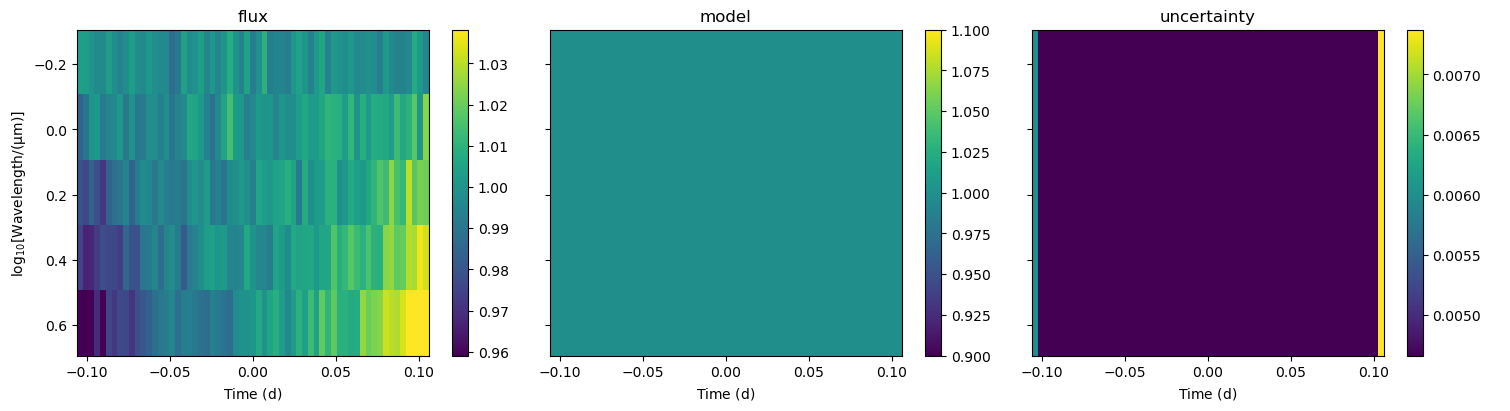

In [2]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=20)

# bin:
nw = 5
rb = r.bin(nwavelengths=int(r.nwave/nw), dt=5 * u.minute)

# create wavelength-dep linear + constant model:
a = 0.0
b = 0.05
c = 0.0
d = 5.0
x = rb.time.to_value("day")

true_a, true_b, true_c, true_d, poly = [],[],[],[],[]

for i in range(rb.nwave):
    true_a.append(a + 1)
    true_b.append(b*i)
    true_c.append(c*i)
    true_d.append(d*i)
    poly.append((d*i*(x**3)) + (c*i*(x**2)) + (b*i*x))
rb.fluxlike['flux'] = rb.flux + np.array(poly)

# plot our Rainbow to see how it looks
rb.imshow_quantities();

Let's plot our data in 2-D so we can see the polynomial shapes we've added:

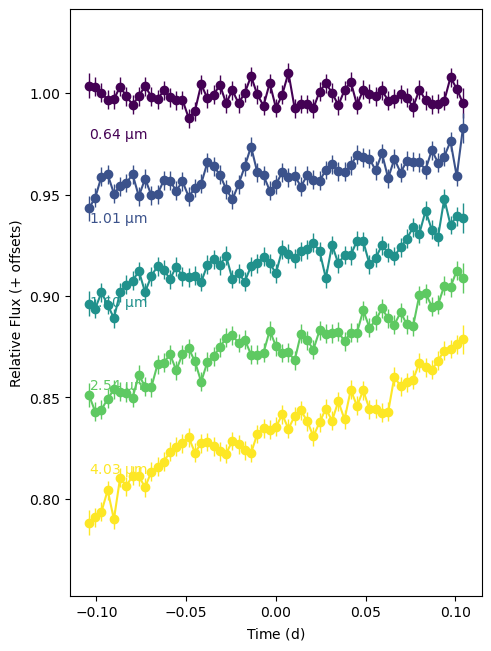

In [3]:
rb.plot_lightcurves();

## Create Polynomial Model

We set up the `PolynomialModel` similarly to the [linear model tutorial](https://catrionamurray.github.io/chromatic_fitting/tutorial_for_linear_fitting/), however, we need to provide the `degree` of the polynomial. By setting this argument we can fix some of our degrees to zero. For example if we have a linear model but we want a zero constant offset we could ignore the `p_0` parameter which would be fixed by default to 0. 

In [4]:
# set up polynomial model:
p = PolynomialModel(degree=3)

p.setup_parameters(
    p_0 = WavelikeFitted(Uniform,testval=[0.01,0.02,0.03,0.04,0.05],upper=2,lower=-2),
    p_1 = WavelikeFitted(Uniform,testval=0.02,upper=1,lower=-1),
    p_2 = WavelikeFitted(Uniform,testval=0.03,upper=1,lower=-1),
    p_3 = WavelikeFitted(Uniform,testval=0.04,upper=25,lower=-5)
)

# print a summary of all params:
p.summarize_parameters()

polynomial_p_0 =
  <🧮 WavelikeFitted Uniform(testval=[0.01, 0.02, 0.03, 0.04, 0.05], upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>

polynomial_p_3 =
  <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>



In [5]:
p.parameters

{'polynomial_p_0': <🧮 WavelikeFitted Uniform(testval=[0.01, 0.02, 0.03, 0.04, 0.05], upper=2, lower=-2, name='polynomial_p_0') for each wavelength 🧮>,
 'polynomial_p_1': <🧮 WavelikeFitted Uniform(testval=0.02, upper=1, lower=-1, name='polynomial_p_1') for each wavelength 🧮>,
 'polynomial_p_2': <🧮 WavelikeFitted Uniform(testval=0.03, upper=1, lower=-1, name='polynomial_p_2') for each wavelength 🧮>,
 'polynomial_p_3': <🧮 WavelikeFitted Uniform(testval=0.04, upper=25, lower=-5, name='polynomial_p_3') for each wavelength 🧮>}

In [6]:
# setup model the same way as for the transit model!:
p.attach_data(rb)
p.setup_lightcurves(store_models=True)
p.setup_likelihood()

Let's check our PyMC3 model and make sure that the parameters have been set up okay!

In [8]:
print(p._pymc3_model)

polynomial_p_0_interval__ ~ TransformedDistribution
polynomial_p_1_interval__ ~ TransformedDistribution
polynomial_p_2_interval__ ~ TransformedDistribution
polynomial_p_3_interval__ ~ TransformedDistribution
           polynomial_p_0 ~ Uniform
           polynomial_p_1 ~ Uniform
           polynomial_p_2 ~ Uniform
           polynomial_p_3 ~ Uniform
         polynomial_model ~ Deterministic
                     data ~ Normal


Looks good, now onto sampling our model...

## Sampling our Model

Now we can try to fit our model! Here we will first perform an optimization step (to give our sampling a good first guess) and then the actual NUTS sampling with a number of tuning and draw steps and chains that we define. We can also choose how many cores to assign to this sampling! Bear in mind that we have a decent number of parameters to fit (simultaneously) and so we want to make sure we have enough steps in the MCMC!

In [9]:
# optimize for initial values!
opt = p.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains.
p.sample(start=opt, tune=2000, draws=4000, chains=4, cores=4)

optimizing logp for variables: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


message: Desired error not necessarily achieved due to precision loss.
logp: -6489668.558770588 -> 1166.7524975530307
/Users/camu5866/opt/anaconda3/lib/python3.9/site-packages/pymc3_ext/sampling/sampling.py:109: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [polynomial_p_3, polynomial_p_2, polynomial_p_1, polynomial_p_0]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 9 seconds.


Now we can look at our results:

In [10]:
p.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                             mean        sd   hdi_16%   hdi_84%  mcse_mean  \
polynomial_p_0[0]        0.998401  0.000907  0.997465  0.999261   0.000006   
polynomial_p_0[1]        1.000495  0.000898  0.999623  1.001395   0.000006   
polynomial_p_0[2]        0.999540  0.000909  0.998636  1.000445   0.000005   
polynomial_p_0[3]        1.000027  0.000904  0.999163  1.000942   0.000006   
polynomial_p_0[4]        0.999756  0.000902  0.998881  1.000680   0.000005   
...                           ...       ...       ...       ...        ...   
polynomial_model[4, 56]  1.033496  0.001443  1.032058  1.034922   0.000010   
polynomial_model[4, 57]  1.036091  0.001585  1.034578  1.037720   0.000011   
polynomial_model[4, 58]  1.038833  0.001748  1.037087  1.040569   0.000013   
polynomial_model[4, 59]  1.041726  0.001933  1.040014  1.043868   0.000014   
polynomial_model[4, 60]  1.044777  0.002139  1.042823  1.047082   0.000017   

                          mcse_sd      ess_bulk      ess_tail  

r_hat parameters are close to 1, which is a good sign that our chains have converged!

In [11]:
p.get_results(uncertainty=['hdi_16%','hdi_84%'])

,polynomial_p_0,polynomial_p_0_hdi_16%,polynomial_p_0_hdi_84%,polynomial_p_1,polynomial_p_1_hdi_16%,polynomial_p_1_hdi_84%,polynomial_p_2,polynomial_p_2_hdi_16%,polynomial_p_2_hdi_84%,polynomial_p_3,polynomial_p_3_hdi_16%,polynomial_p_3_hdi_84%,wavelength
w0,0.998401,0.997465,0.999261,0.004664,-0.010748,0.028526,0.071907,-0.117887,0.251437,-0.916521,-4.649307,0.381307,0.639572482934883 micron
w1,1.000495,0.999623,1.001395,0.072177,0.050827,0.097482,0.178895,-0.003798,0.364595,1.331657,-2.26488,4.300365,1.013209338074884 micron
w2,0.99954,0.998636,1.000445,0.066568,0.041523,0.089843,0.100315,-0.079025,0.28654,15.540161,11.946842,18.807036,1.604998553797903 micron
w3,1.000027,0.999163,1.000942,0.119587,0.092361,0.138253,-0.027549,-0.20617,0.160212,19.056094,16.269967,22.640701,2.542436455025025 micron
w4,0.999756,0.998881,1.00068,0.195818,0.174641,0.211134,0.030724,-0.155268,0.215136,21.489959,20.568979,24.957682,4.027407446906737 micron


In [12]:
model = p.get_model()
model.keys()

dict_keys(['w0', 'w1', 'w2', 'w3', 'w4'])

## Plot Results

Remember that handy `plot_lightcurves()` function from earlier? Once we have generated a model it *should* now overplot those models on top of the data.

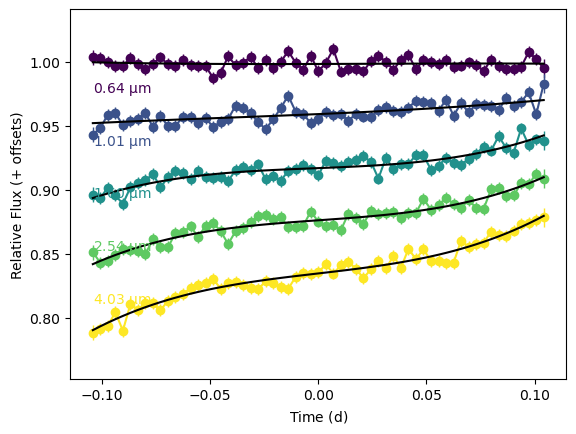

In [13]:
p.plot_lightcurves()

We can also use the `chromatic` functions wrapped in `chromatic_fitting` that can let us look at the residuals:

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


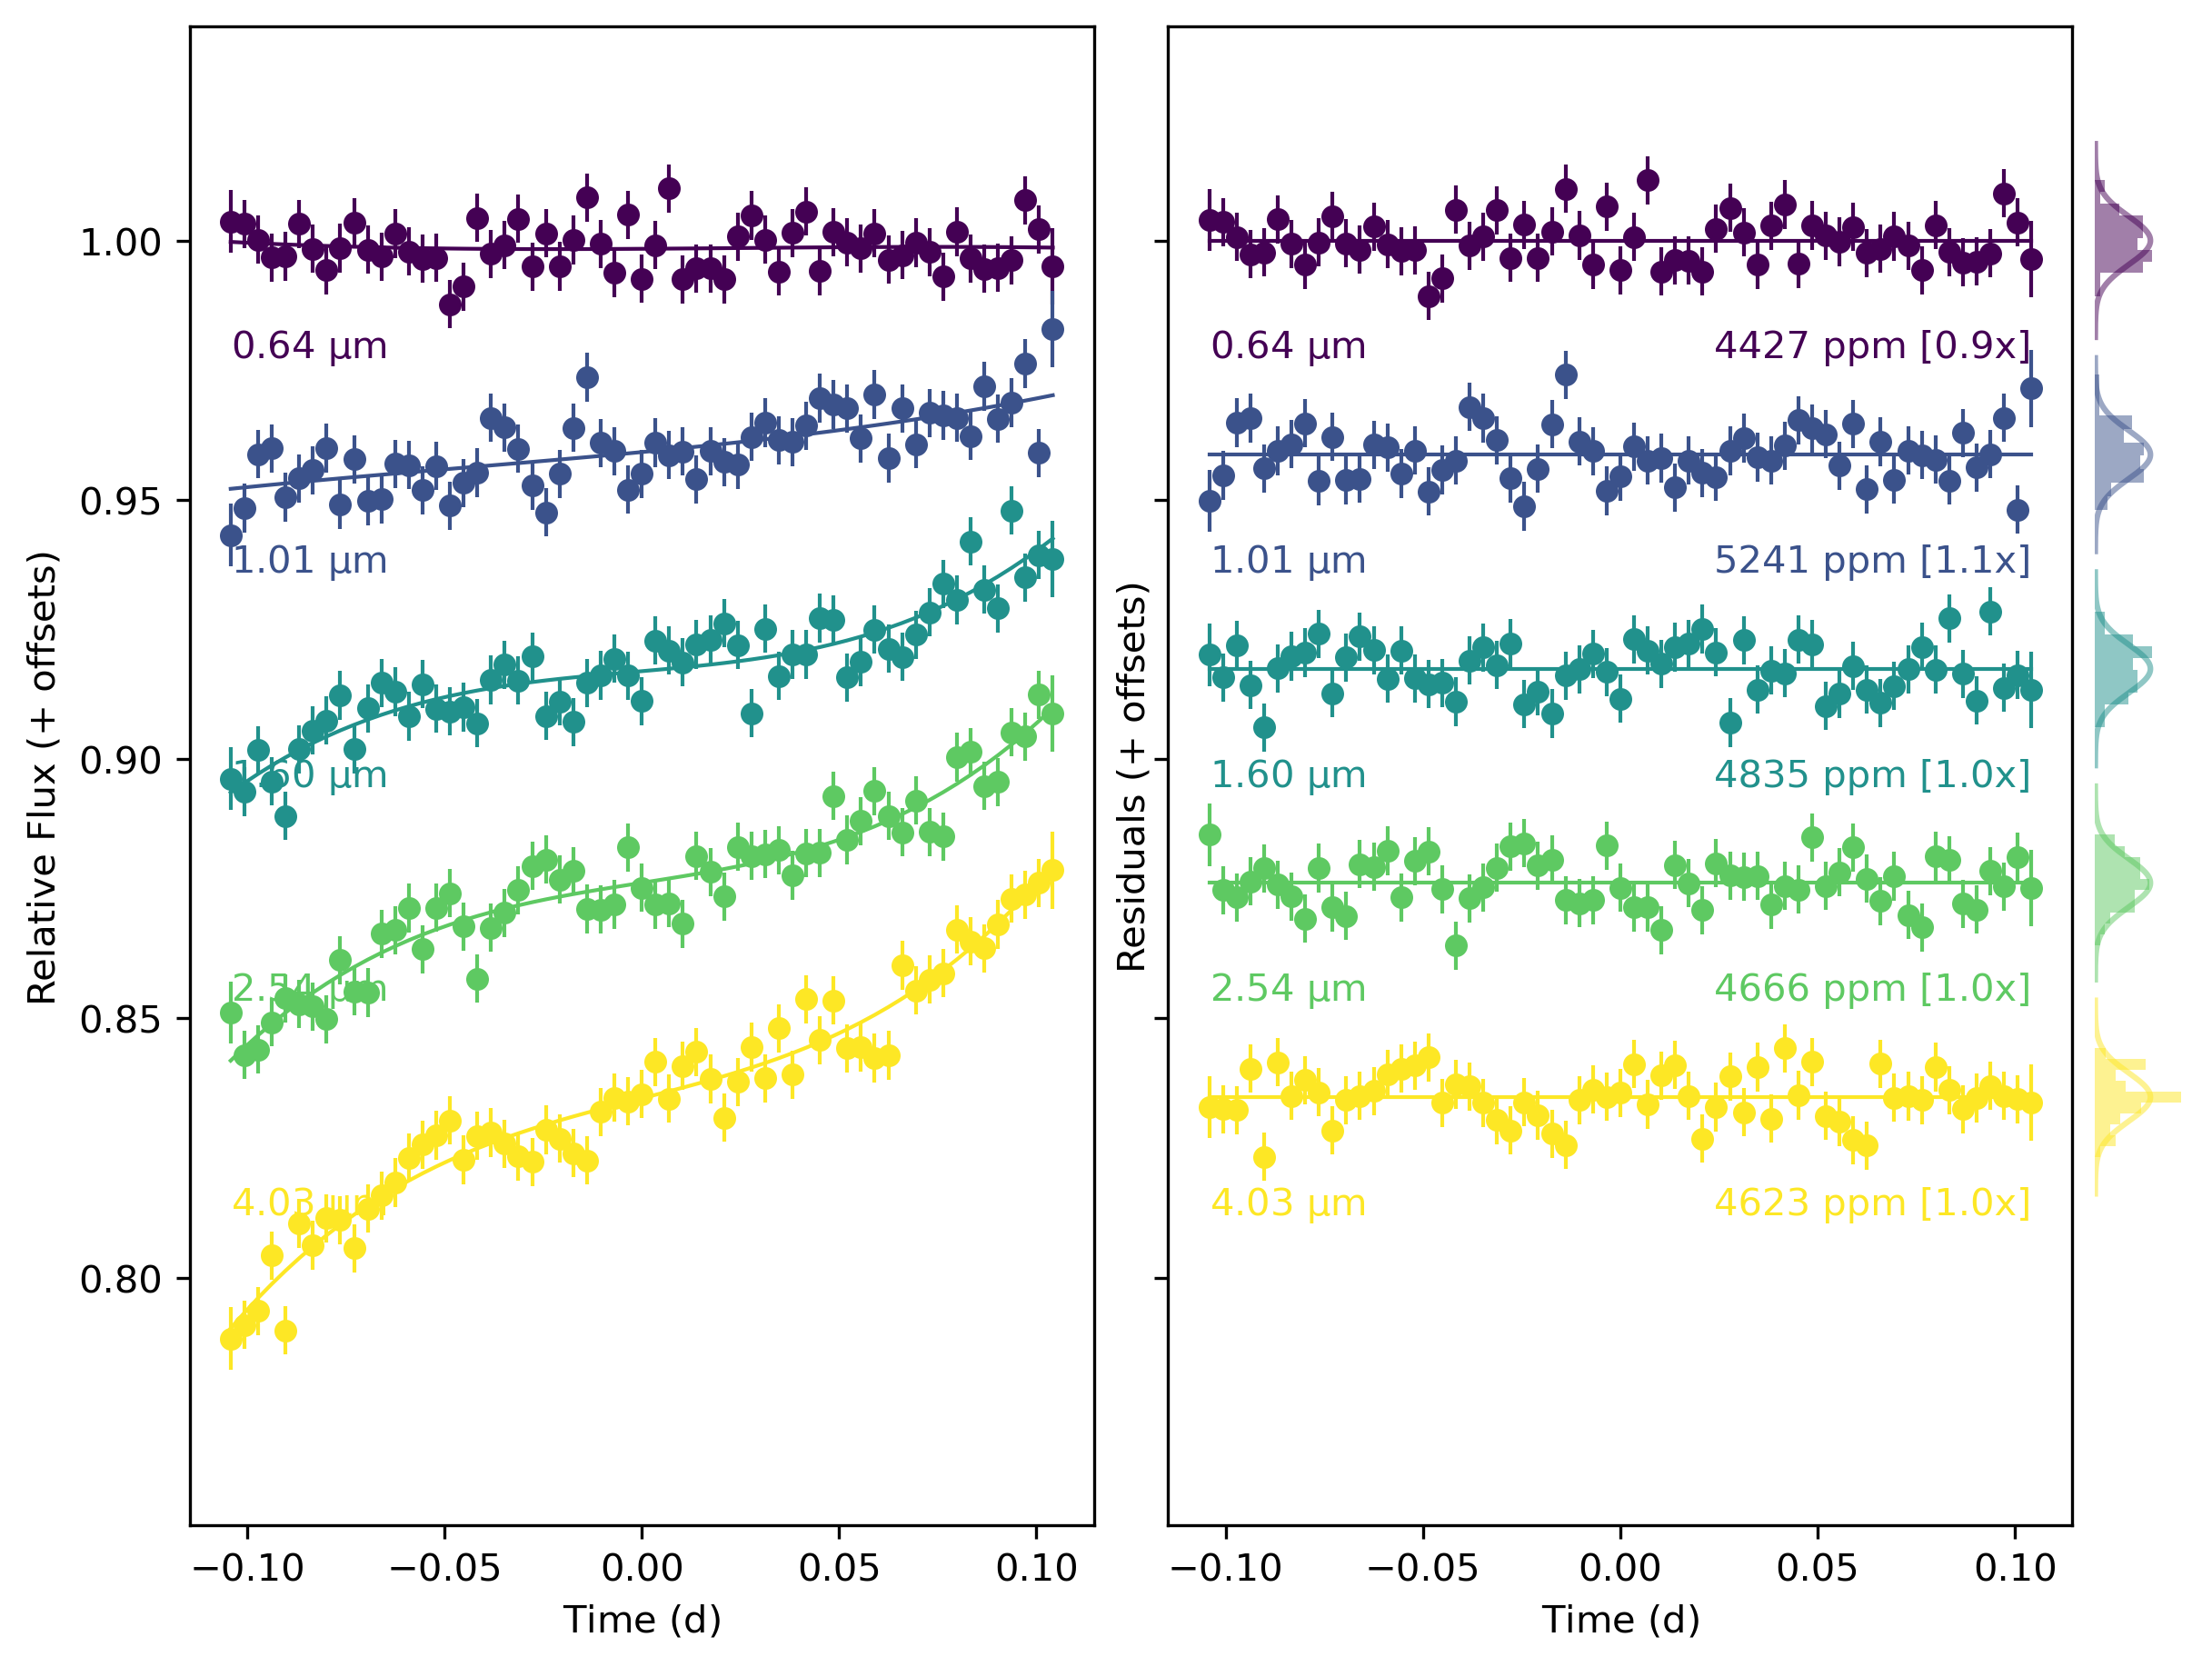

In [14]:
p.plot_with_model_and_residuals()

🌈🤖 'planet_model' doesn't exist and will be skipped.



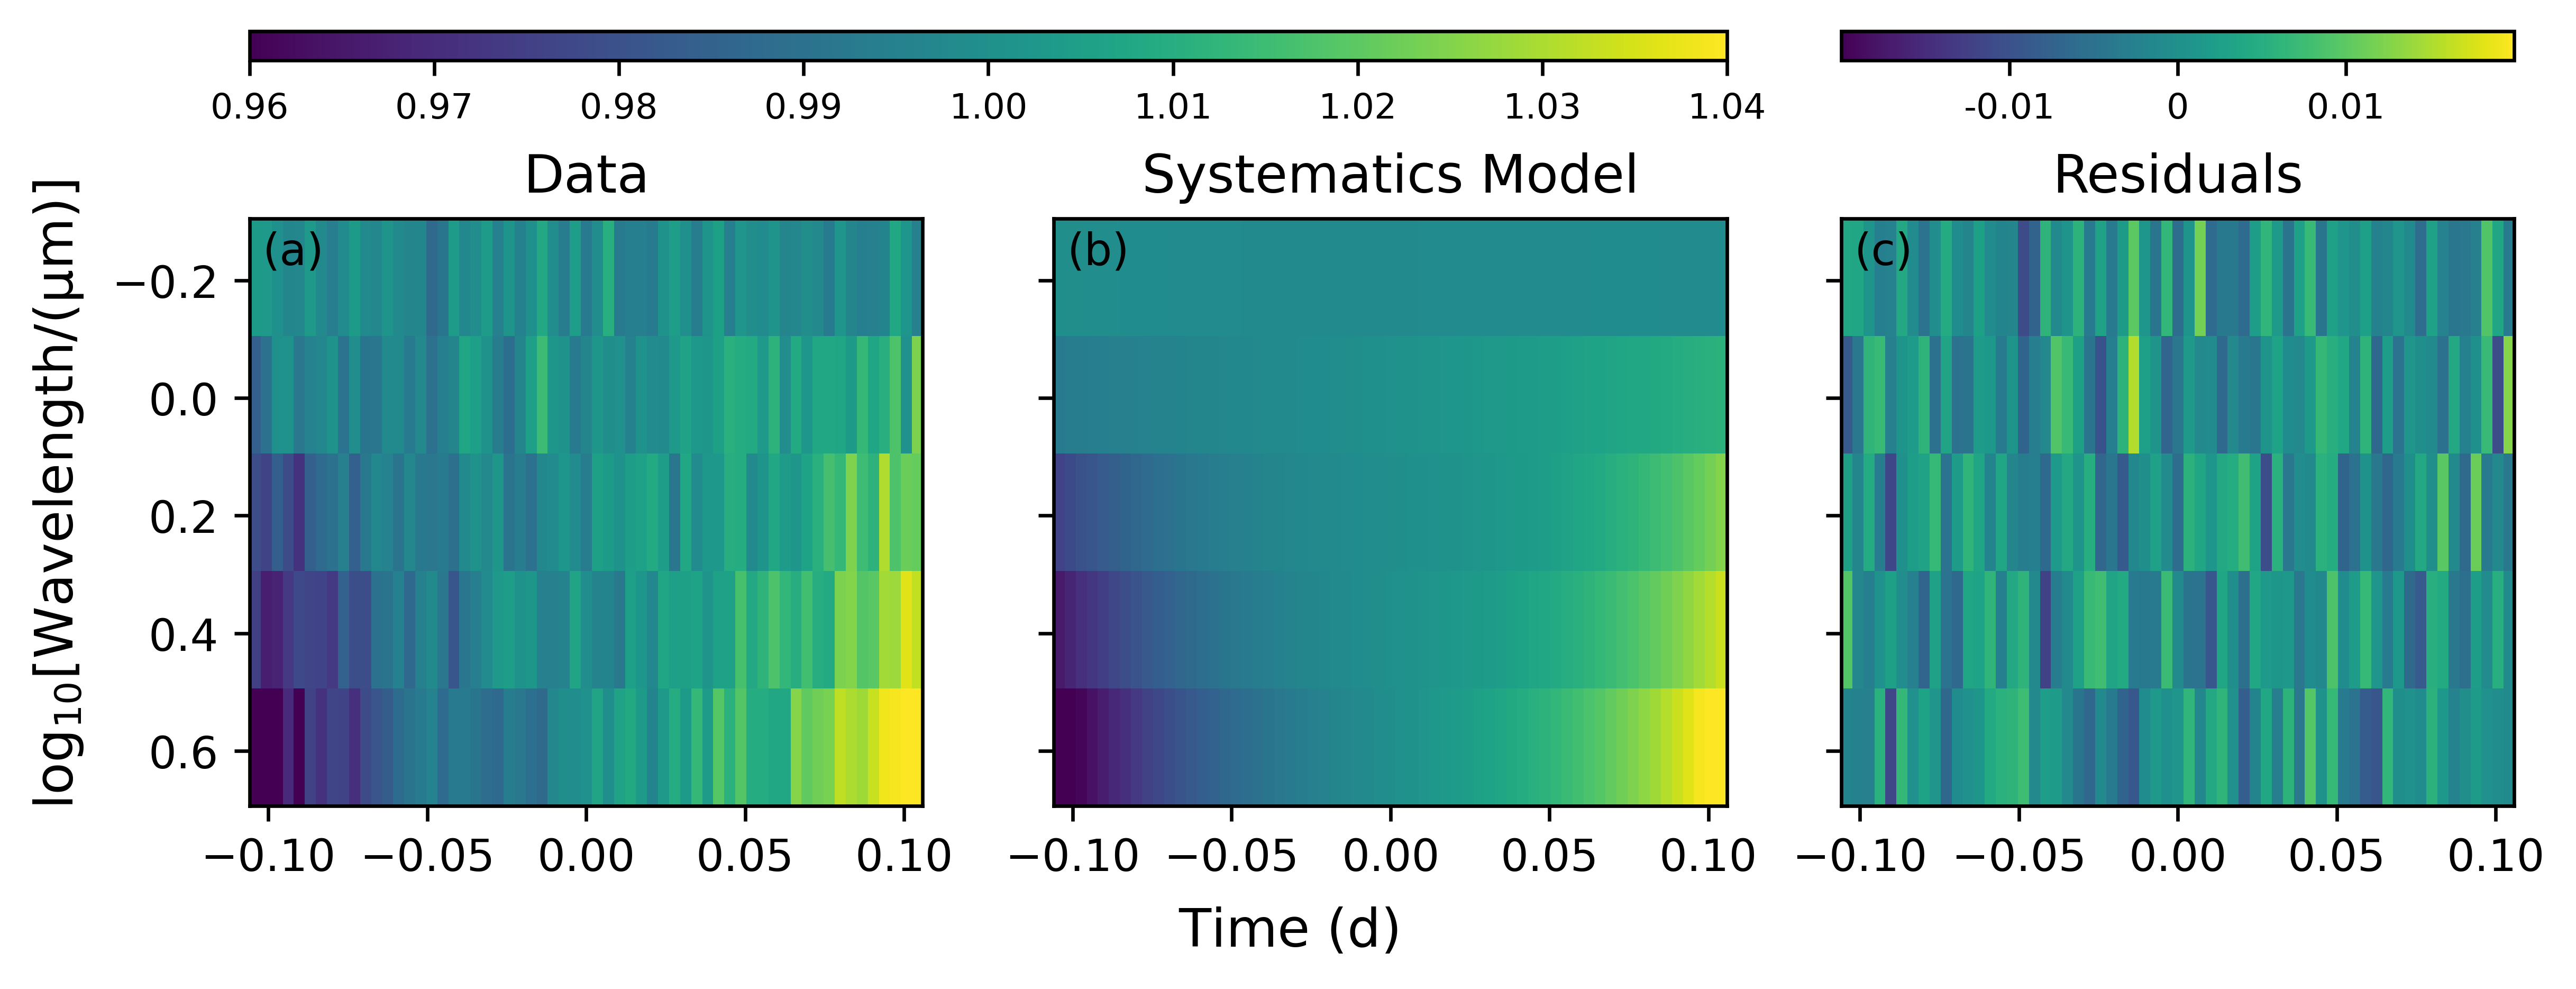

In [15]:
p.imshow_with_models(vlimits_data=[0.96, 1.04])

## Compare Results to the True Values

We can also compare our fitted results to the true values we put in:

In [16]:
results = p.get_results(uncertainty=['sd','sd'])
results

,polynomial_p_0,polynomial_p_0_sd,polynomial_p_1,polynomial_p_1_sd,polynomial_p_2,polynomial_p_2_sd,polynomial_p_3,polynomial_p_3_sd,wavelength
w0,0.998401,0.000907,0.004664,0.020033,0.071907,0.188418,-0.916521,2.636489,0.639572482934883 micron
w1,1.000495,0.000898,0.072177,0.023013,0.178895,0.186229,1.331657,3.199005,1.013209338074884 micron
w2,0.99954,0.000909,0.066568,0.024269,0.100315,0.185468,15.540161,3.427899,1.604998553797903 micron
w3,1.000027,0.000904,0.119587,0.022702,-0.027549,0.184707,19.056094,3.121383,2.542436455025025 micron
w4,0.999756,0.000902,0.195818,0.018622,0.030724,0.185158,21.489959,2.414689,4.027407446906737 micron


In [17]:
print("\t\t\tTrue, \tFitted")
for w in range(p.data.nwave):
    for i, coeff in zip(range(p.degree+1),[true_a, true_b, true_c, true_d]):
        print(f"wavelength {w}, p_{i}:\t {round(coeff[w],2)}, \t",results.loc[f'w{w}'][f"{p.name}_p_{i}"],"+/-",results.loc[f'w{w}'][f"{p.name}_p_{i}_sd"])

			True, 	Fitted
wavelength 0, p_0:	 1.0, 	 0.9984013 +/- 0.0009067
wavelength 0, p_1:	 0.0, 	 0.0046639 +/- 0.0200331
wavelength 0, p_2:	 0.0, 	 0.0719071 +/- 0.1884176
wavelength 0, p_3:	 0.0, 	 -0.9165207 +/- 2.6364888
wavelength 1, p_0:	 1.0, 	 1.0004945 +/- 0.0008981
wavelength 1, p_1:	 0.05, 	 0.0721774 +/- 0.0230134
wavelength 1, p_2:	 0.0, 	 0.1788949 +/- 0.1862295
wavelength 1, p_3:	 5.0, 	 1.3316566 +/- 3.1990053
wavelength 2, p_0:	 1.0, 	 0.9995396 +/- 0.0009093
wavelength 2, p_1:	 0.1, 	 0.0665678 +/- 0.0242688
wavelength 2, p_2:	 0.0, 	 0.100315 +/- 0.1854682
wavelength 2, p_3:	 10.0, 	 15.5401609 +/- 3.4278994
wavelength 3, p_0:	 1.0, 	 1.0000267 +/- 0.000904
wavelength 3, p_1:	 0.15, 	 0.1195871 +/- 0.0227019
wavelength 3, p_2:	 0.0, 	 -0.0275493 +/- 0.1847067
wavelength 3, p_3:	 15.0, 	 19.0560939 +/- 3.1213835
wavelength 4, p_0:	 1.0, 	 0.999756 +/- 0.0009017
wavelength 4, p_1:	 0.2, 	 0.1958175 +/- 0.0186222
wavelength 4, p_2:	 0.0, 	 0.0307237 +/- 0.1851577
wavelengt

Let's plot the data, the true regression line and our fit and see how they compare (If we used `store_model=True` at the `.setup_lightcurves()` stage then we could easily generate a 1-sigma region for the model using the errors stored in the summary table!):

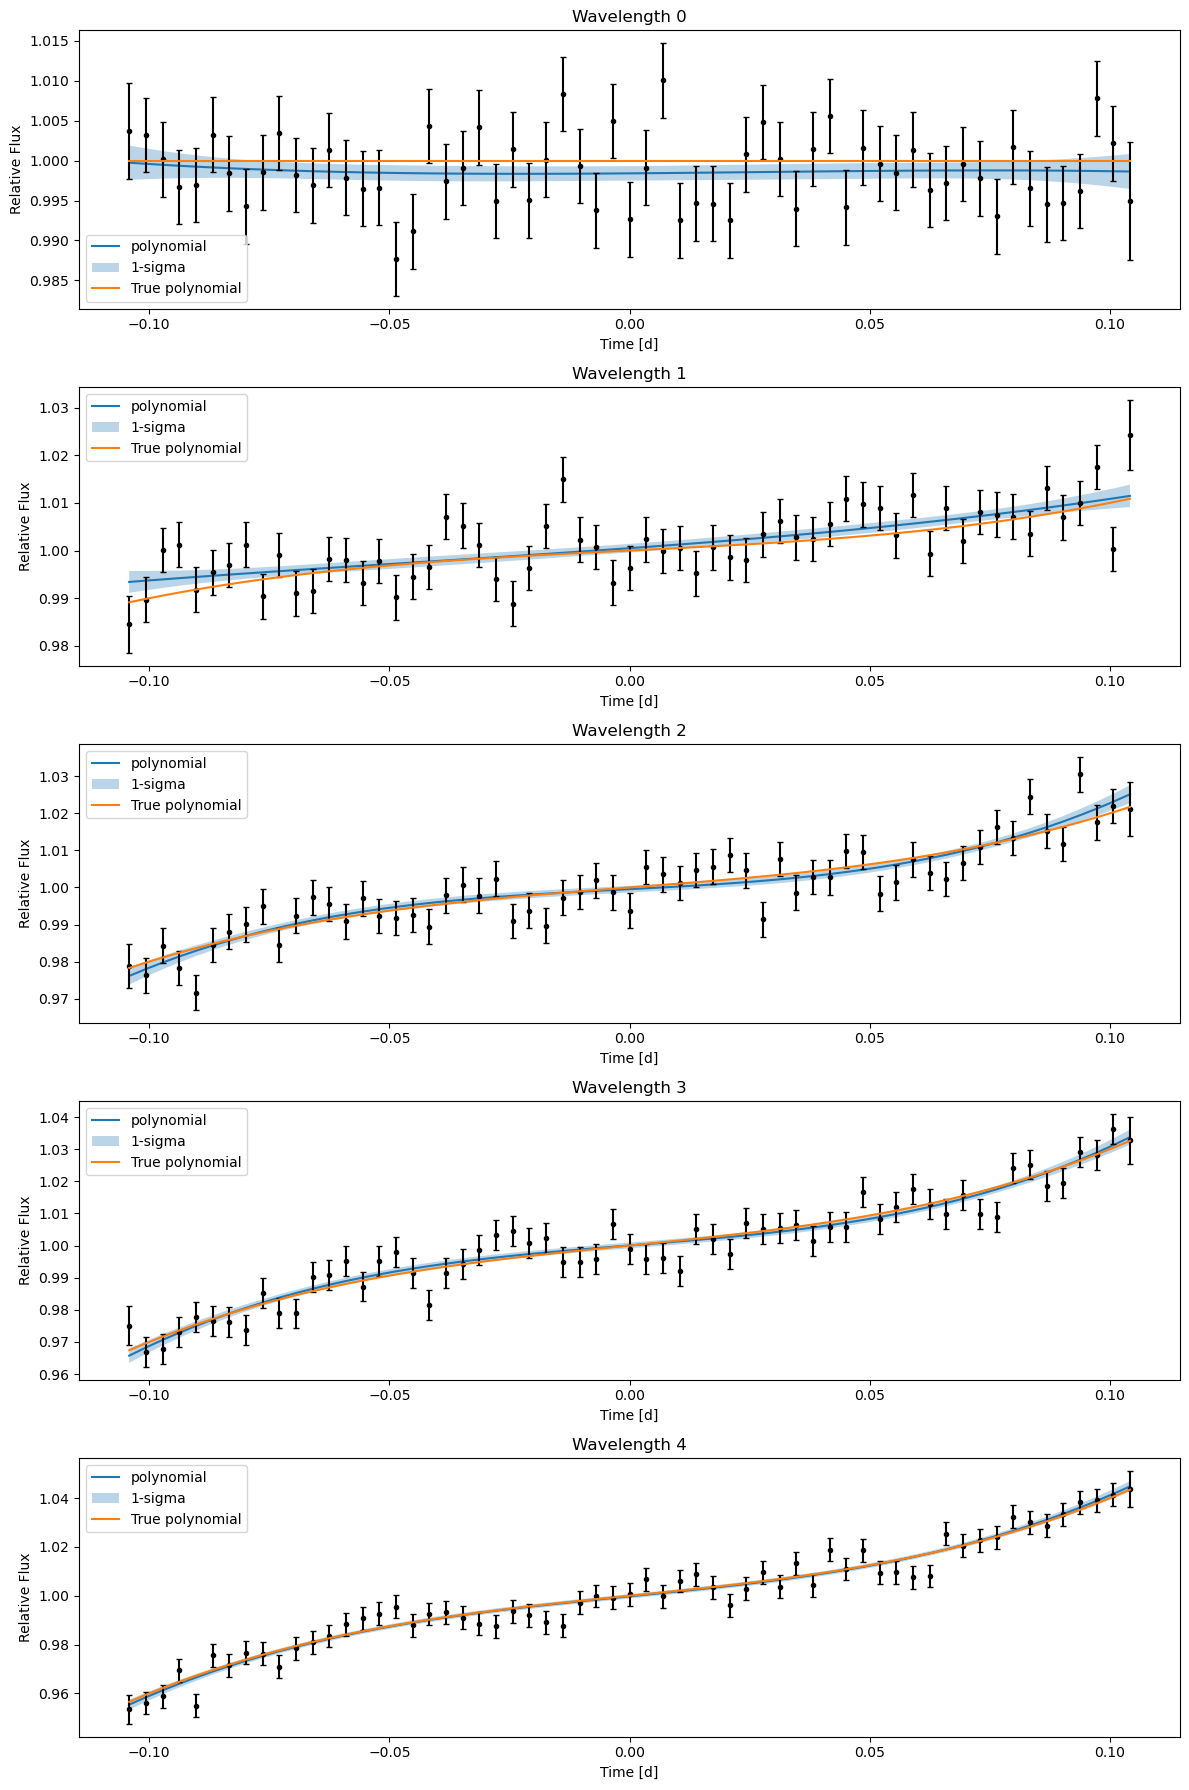

In [18]:
fig, ax = plt.subplots(p.data.nwave, figsize=(12,18))
p.plot_model(ax=ax)
plt.tight_layout();

# get 1-sigma region (only if store_models=True!!):
onesigma={}
for w in range(p.data.nwave):
    if f"w{w}" not in onesigma.keys():
        onesigma[f"w{w}"] = []
    for t in range(p.data.ntime):
        onesigma[f"w{w}"].append(p.summary["sd"][f"{p.name}_model[{w}, {t}]"])
        
        
for i in range(len(poly)):
    ax[i].fill_between(p.data.time.to_value("d"), np.array(model[f"w{i}"])-onesigma[f"w{i}"], np.array(model[f"w{i}"])+onesigma[f"w{i}"], label='1-sigma', alpha=0.3)
    ax[i].plot(p.data.time, poly[i] + 1, label="True polynomial")
    ax[i].legend()

This is a good example to see where the model does a good job of fitting, and where, when the noise is larger than the signal, it can overfit (wavelength 0).